# Load Data

In [1]:
import os
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

## Load Images

In [3]:
train_images = tf.data.Dataset.list_files('image_data/aug_data_face/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: x/255)

In [4]:
val_images = tf.data.Dataset.list_files('image_data/aug_data_face/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: x/255)

## Load Labels

In [5]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [6]:
train_labels = tf.data.Dataset.list_files('image_data/aug_data_face/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [7]:
val_labels = tf.data.Dataset.list_files('image_data/aug_data_face/validation/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [8]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(16000, 16000, 4000, 4000)

## Load Dataset

In [9]:
train = tf.data.Dataset.zip((train_images, train_labels)).cache()
train = train.shuffle(len(train_images)//3)
train = train.batch(8)
train = train.prefetch(tf.data.AUTOTUNE)

In [10]:
val = tf.data.Dataset.zip((val_images, val_labels)).cache()
val = val.batch(8)
val = val.prefetch(tf.data.AUTOTUNE)

# Nyoba Model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D 
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3, Xception, MobileNetV3Large, InceptionResNetV2, MobileNetV3Small   

In [167]:
mobilenetv3s = MobileNetV3Small(include_top=False, input_shape=(200, 200, 3), include_preprocessing=False)
mobilenetv3s.trainable = False

In [168]:
input_layer = Input(shape=(200,200,3))

x = mobilenetv3s(input_layer, training=False)

# Classification Model  
f1 = GlobalAveragePooling2D()(x)
drop1 = Dropout(0.35)(f1)
class2 = Dense(1, activation='sigmoid', name='face')(drop1)

# Bounding box model
f2 = GlobalAveragePooling2D()(x)
drop2 = Dropout(0.2)(f2)
regress2 = Dense(4, activation='sigmoid', name='bbox')(drop2)

model = Model(inputs=input_layer, outputs=[class2, regress2])

In [169]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.93,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)

In [148]:
initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.99)

In [143]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [172]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

In [173]:
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [174]:
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[callback])

Epoch 1/100
2000/2000 [==============================] - 68s 28ms/step - loss: 6.1503 - face_loss: 0.4347 - bbox_loss: 1.8032 - val_loss: 4.4040 - val_face_loss: 0.3200 - val_bbox_loss: 1.2037
Epoch 2/100
2000/2000 [==============================] - 57s 28ms/step - loss: 4.3226 - face_loss: 0.3111 - bbox_loss: 1.2120 - val_loss: 3.7978 - val_face_loss: 0.2762 - val_bbox_loss: 1.0360
Epoch 3/100
2000/2000 [==============================] - 60s 30ms/step - loss: 3.8959 - face_loss: 0.2798 - bbox_loss: 1.0974 - val_loss: 3.5399 - val_face_loss: 0.2567 - val_bbox_loss: 0.9728
Epoch 4/100
2000/2000 [==============================] - 59s 29ms/step - loss: 3.7112 - face_loss: 0.2663 - bbox_loss: 1.0484 - val_loss: 3.4007 - val_face_loss: 0.2462 - val_bbox_loss: 0.9385
Epoch 5/100
2000/2000 [==============================] - 58s 29ms/step - loss: 3.5487 - face_loss: 0.2544 - bbox_loss: 1.0043 - val_loss: 3.2990 - val_face_loss: 0.2384 - val_bbox_loss: 0.9152
Epoch 6/100
2000/2000 [============

## Mobilenet v2

### global avg

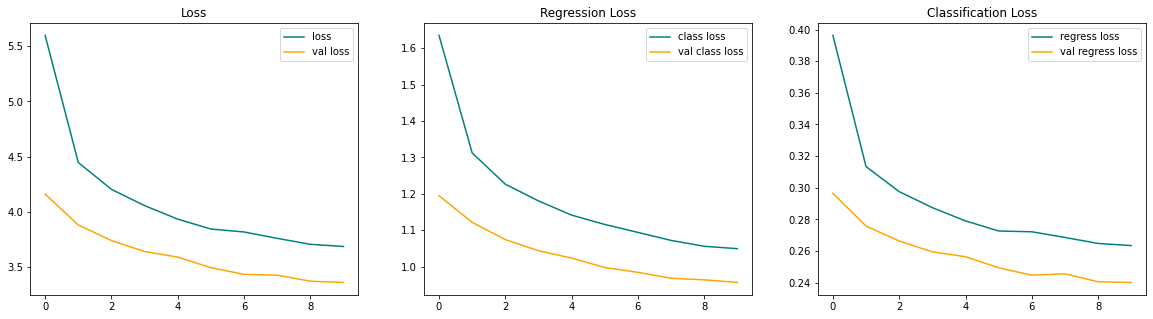

In [33]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

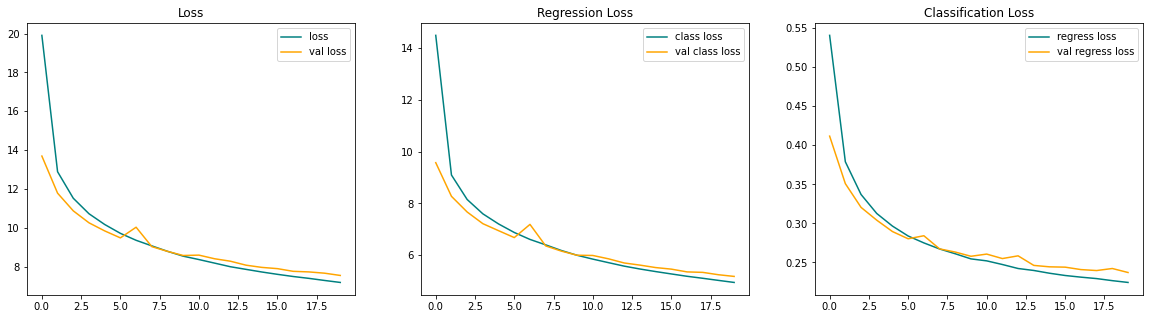

In [164]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 small

### global avg sgd

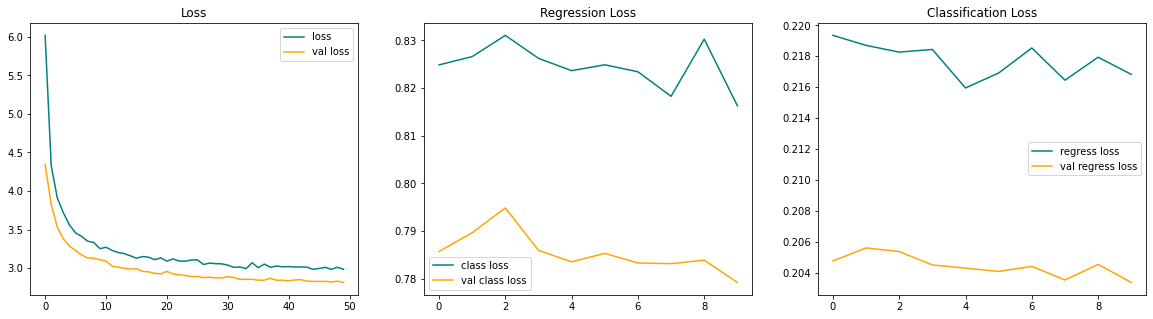

In [160]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'][40:], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'][40:], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'][40:], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'][40:], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg adam

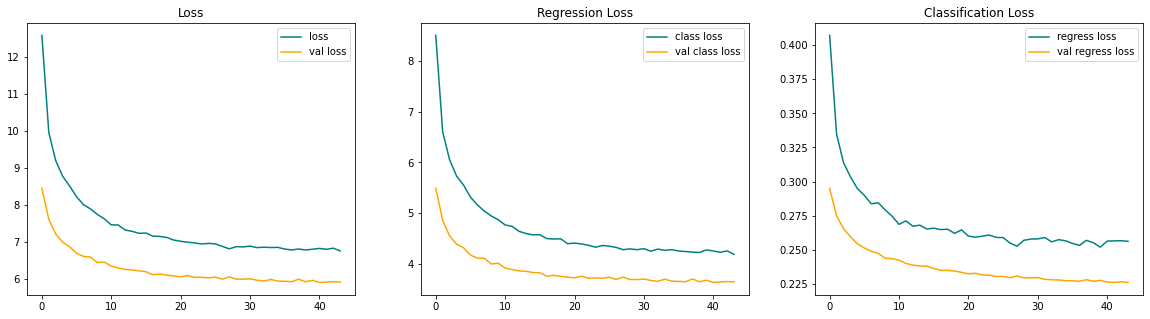

In [190]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 large

### global avg

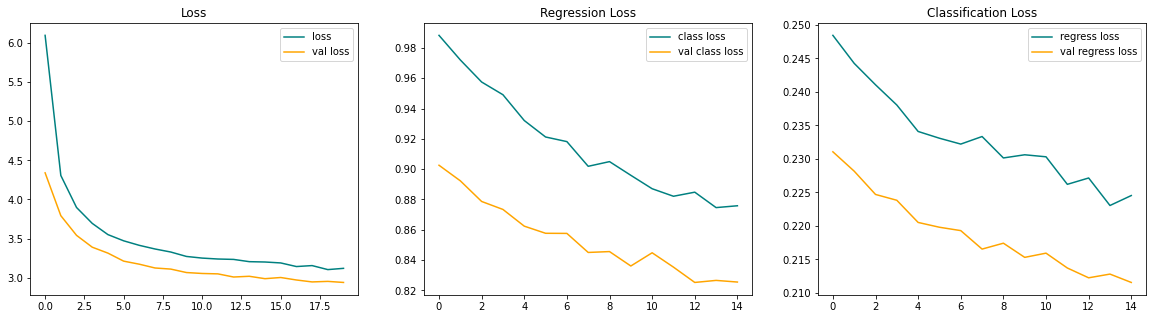

In [104]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'][5:], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'][5:], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'][5:], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'][5:], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

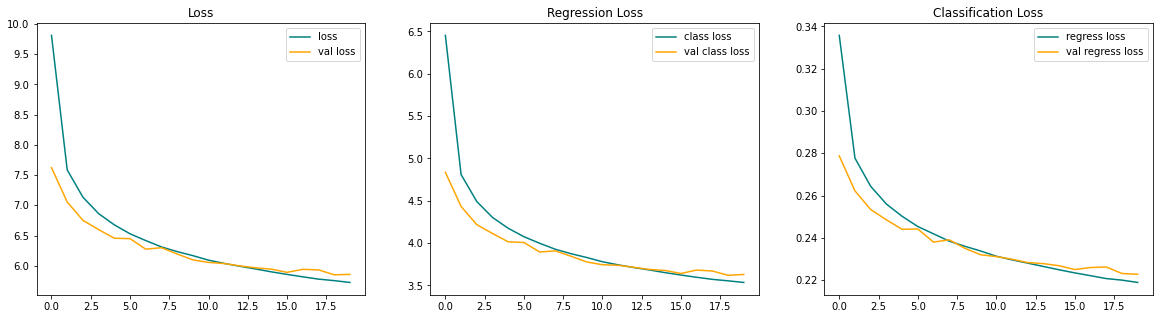

In [185]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg

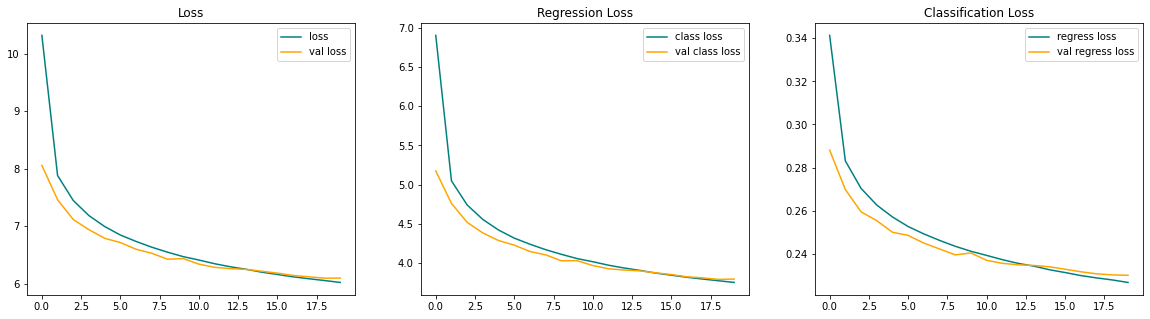

In [175]:
#mv2 avg 0.0001
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [175]:
mobilenetv3s.trainable = True

In [162]:
mobilenetv3s.layers[179]

In [176]:
for layer in mobilenetv3s.layers[:191]:
  layer.trainable = False

In [164]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
MobilenetV3small (Functional)   (None, 1, 1, 1024)   1529968     input_21[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_29 (Gl (None, 1024)         0           MobilenetV3small[0][0]           
__________________________________________________________________________________________________
global_average_pooling2d_30 (Gl (None, 1024)         0           MobilenetV3small[0][0]           
___________________________________________________________________________________________

In [177]:
initial_learning_rate = 8e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [178]:
hist = model.fit(train, epochs=200, initial_epoch=hist.epoch[-1], validation_data=val, callbacks=[callback])

Epoch 63/200
2000/2000 [==============================] - 95s 39ms/step - loss: 2.9772 - face_loss: 0.2165 - bbox_loss: 0.8122 - val_loss: 2.7580 - val_face_loss: 0.1988 - val_bbox_loss: 0.7699
Epoch 64/200
2000/2000 [==============================] - 76s 38ms/step - loss: 2.9147 - face_loss: 0.2122 - bbox_loss: 0.7929 - val_loss: 2.7286 - val_face_loss: 0.1965 - val_bbox_loss: 0.7640
Epoch 65/200
2000/2000 [==============================] - 76s 38ms/step - loss: 2.8682 - face_loss: 0.2079 - bbox_loss: 0.7891 - val_loss: 2.7196 - val_face_loss: 0.1956 - val_bbox_loss: 0.7633
Epoch 66/200
2000/2000 [==============================] - 75s 38ms/step - loss: 2.8256 - face_loss: 0.2040 - bbox_loss: 0.7851 - val_loss: 2.6748 - val_face_loss: 0.1922 - val_bbox_loss: 0.7524
Epoch 67/200
2000/2000 [==============================] - 77s 38ms/step - loss: 2.7970 - face_loss: 0.2021 - bbox_loss: 0.7760 - val_loss: 2.6607 - val_face_loss: 0.1911 - val_bbox_loss: 0.7502
Epoch 68/200
2000/2000 [======

2000/2000 [==============================] - 80s 39ms/step - loss: 2.0088 - face_loss: 0.1411 - bbox_loss: 0.5982 - val_loss: 2.2144 - val_face_loss: 0.1567 - val_bbox_loss: 0.6477
Epoch 147/200
2000/2000 [==============================] - 82s 41ms/step - loss: 2.0030 - face_loss: 0.1411 - bbox_loss: 0.5925 - val_loss: 2.2111 - val_face_loss: 0.1564 - val_bbox_loss: 0.6469
Epoch 148/200
2000/2000 [==============================] - 82s 41ms/step - loss: 2.0068 - face_loss: 0.1410 - bbox_loss: 0.5963 - val_loss: 2.2051 - val_face_loss: 0.1560 - val_bbox_loss: 0.6451
Epoch 149/200
2000/2000 [==============================] - 81s 40ms/step - loss: 2.0042 - face_loss: 0.1409 - bbox_loss: 0.5951 - val_loss: 2.2053 - val_face_loss: 0.1560 - val_bbox_loss: 0.6453
Epoch 150/200
2000/2000 [==============================] - 81s 40ms/step - loss: 2.0023 - face_loss: 0.1414 - bbox_loss: 0.5880 - val_loss: 2.2033 - val_face_loss: 0.1558 - val_bbox_loss: 0.6448
Epoch 151/200
2000/2000 [==============

### global avg fine-tuning

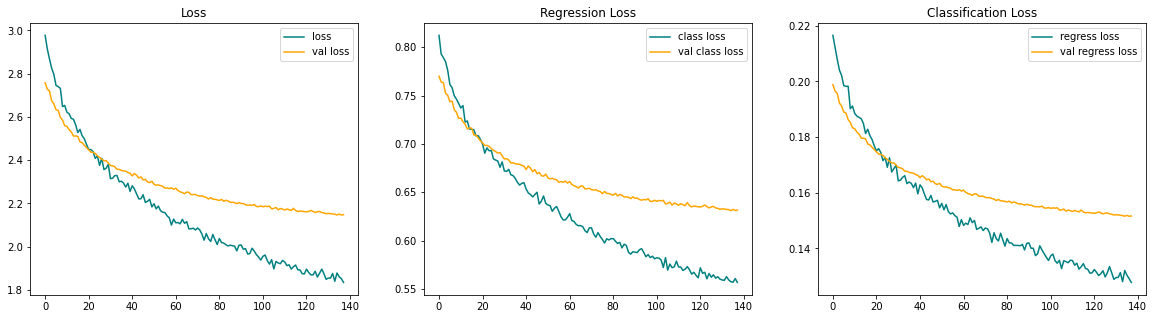

In [179]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max fine-tuning

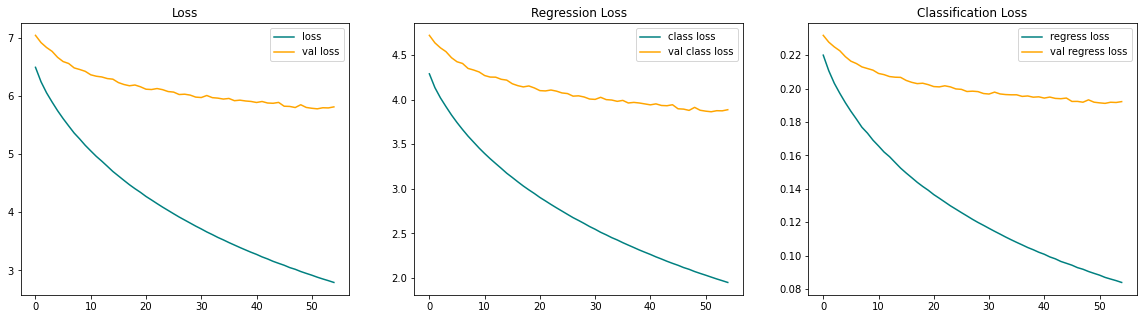

In [31]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [234]:
val_data = val.as_numpy_iterator()

In [237]:
test_sample = val_data.next()
yhat = model.predict(val)

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,20))
idx = 0

for i in range(2):
  for j in range(4):
    sample_image = val_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
                            (255,0,0), 2)
    ax[i][j].imshow(sample_image)
    idx += 1

# for idx in range(16):
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
#                             (255,0,0), 2)
#     ax[idx].imshow(sample_image)

In [180]:
from tensorflow.keras.models import load_model

In [190]:
model.save('model.h5')

In [182]:
tf.saved_model.save(model, 'model')

INFO:tensorflow:Assets written to: model\assets


In [183]:
converter = tf.lite.TFLiteConverter.from_saved_model('model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [185]:
loaded = tf.saved_model.load('model')
print(list(loaded.signatures.keys()))

['serving_default']


In [192]:
model.save_weights('model_weights.h5')

In [194]:
savedModel = model.load_weights('model_weights.h5')
print('Model Loaded!')

Model Loaded!
